# Titanic: Logistic Regression Example
#### http://www.data-mania.com/blog/logistic-regression-example-in-python/

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

## Logistic regression on the Titanic dataset
* We will put this data into a Pandas DataFrame, called __`titanic`__, and name each of the columns

In [5]:
!wget https://raw.githubusercontent.com/davewadestein/Gap-Python-2025/refs/heads/main/Data/titanic.csv

--2025-01-12 19:34:17--  https://raw.githubusercontent.com/davewadestein/Gap-Python-2025/refs/heads/main/Data/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.06s   

2025-01-12 19:34:18 (1.03 MB/s) - ‘titanic.csv’ saved [60302/60302]



In [6]:
titanic = pd.read_csv('titanic.csv')
titanic.columns = 'PassengerId Survived Pclass Name Sex Age SibSp Parch Ticket Fare Cabin Embarked'.split()
titanic.head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### Checking that your target variable is binary
Since we are building a model to predict survival of passengers from the Titanic, our target is going to be "Survived" variable from the titanic dataframe. To make sure that it's a binary variable, let's use Seaborn's __`countplot()`__ function.

<ipython-input-7-eba597c8da4e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='Survived',data=titanic, palette='hls');


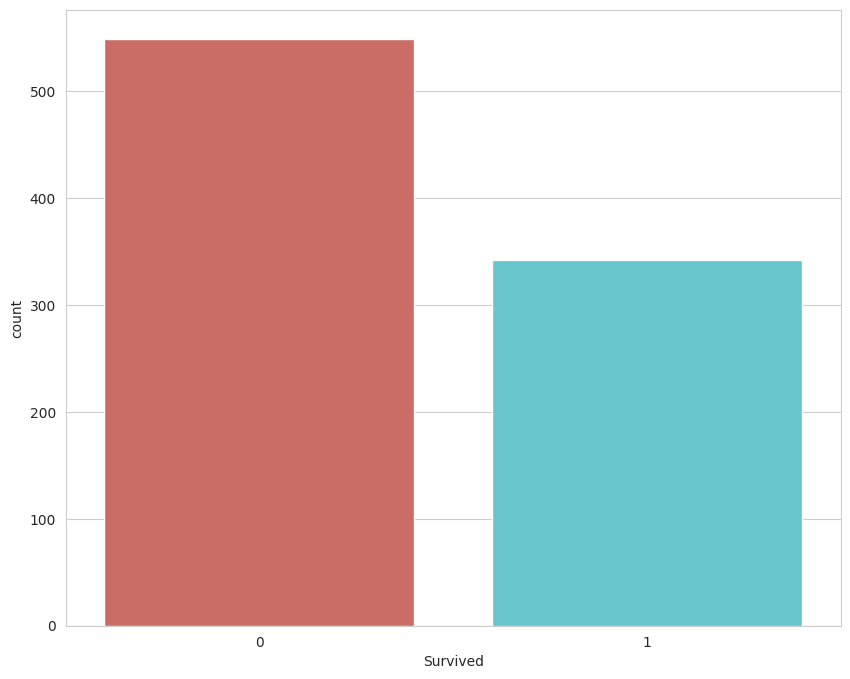

In [7]:
sb.countplot(x='Survived',data=titanic, palette='hls');

Ok, so we the __Survived__ variable is binary (0 - did not survive / 1 - survived)

### Checking for missing values
It's easy to check for missing values by calling the __`isnull()`__ method, and the __`sum()`__ method off of that, to return a tally of all the True values that are returned by the __`isnull()`__ method.

In [8]:
titanic.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## How many records are there in the DataFrame?

In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Ok, so there are only 891 rows in the titanic data frame
* __Cabin__ is almost all missing values, so we can drop that variable completely
* What about age? Age seems like a relevant predictor for survival, right? We'd want to keep the variables, but it has 177 missing values. Yikes!! We are going to need to find a way to approximate for those missing values!

## Taking care of missing values
### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- __Survived__ - This variable is obviously relevant
- __Pclass__ - Does a passenger's class on the boat affect their survivability?
- __Sex__ - Could a passenger's gender impact their survival rate?
- __Age__ - Does a person's age impact their survival rate?
- __SibSp__ - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probably
- __Parch__ - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probably
- __Fare__ - Does the fare a person paid affect his survivability? Maybe - let's keep it.
- __Embarked__ - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

* What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [10]:
titanic_data = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


* Now we have the DataFrame reduced down to only relevant variables, but now we need to deal with the missing values in the age variable.

### Imputing missing values
Let's look at how passenger age is related to their class as a passenger on the ship

<ipython-input-11-d3fe27cc9605>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls');


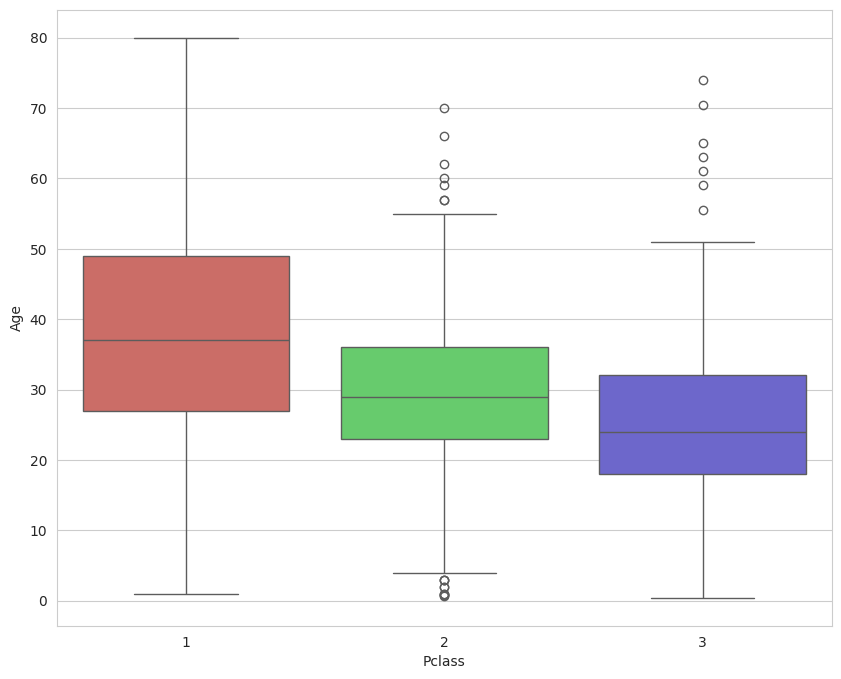

In [11]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls');

In [12]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. The older a passenger is, the more likely it is for them to be in 1st class. So there is a loose relationship between these variables. So, let's write a function that approximates a passengers age, based on their class. From the box plot, it looks like the average age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

So let's write a function that finds each null value in the Age variable, and for each null, checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.

In [13]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    class_to_age = { 1: 37, 2: 29, 3: 24 }

    if pd.isnull(Age):
        return class_to_age[Pclass]
    else:
        return Age

When we apply the function and check again for null values, we see that there are no more null values in the age variable.

In [14]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

<ipython-input-13-c9dc459f2c01>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
<ipython-input-13-c9dc459f2c01>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,2


* There are 2 null values in the embarked variable. We can drop those 2 records without losing too much important information from our dataset, so we will do that.

In [15]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


### Converting categorical variables to a dummy variables
The next thing we need to do is reformat our variables so that they work with the model. Specifically, we need to reformat the __Sex__ and __Embarked__ variables into numeric variables.

In [16]:
gender = pd.get_dummies(titanic_data['Sex'], drop_first=True)
gender.head()

,male
0,True
1,False
2,False
3,False
4,True


In [17]:
embark_location = pd.get_dummies(titanic_data['Embarked'], drop_first=True)
embark_location.head(25)

,Q,S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True
5,True,False
6,False,True
7,False,True
8,False,True
9,False,False


In [ ]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [18]:
titanic_data.drop(['Sex', 'Embarked'], axis=1, inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [19]:
titanic_dmy = pd.concat([titanic_data, gender, embark_location], axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


Now we have a dataset with all the variables in the correct format!

### Checking for independence between features

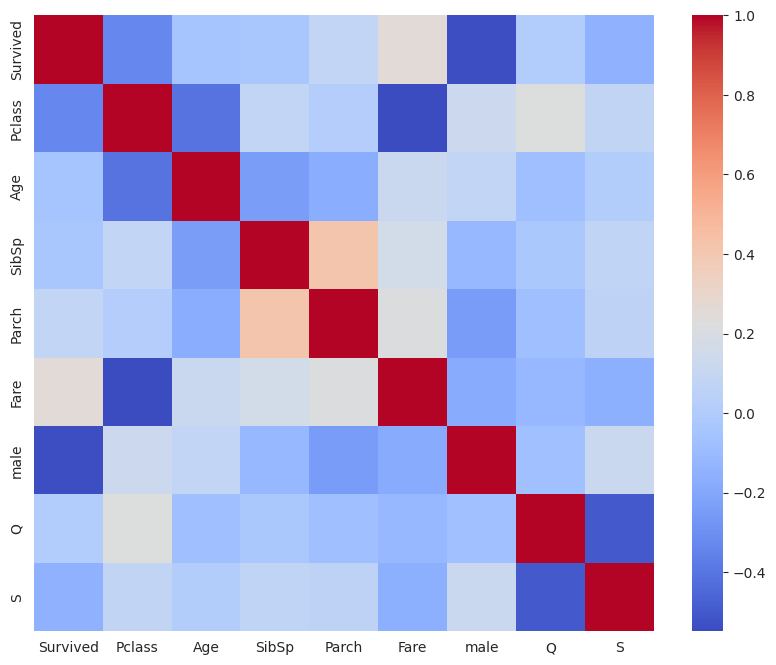

In [20]:
sb.heatmap(titanic_dmy.corr(), cmap='coolwarm');

### "__Fare__ and __Pclass__ are not independent of each other, so I am going to drop these."

(The above are the exact words of Lillian Pierson, yet they are confusing. We'd expect to keep one of them and not the other. A later comment by her suggests the she was concerned about multicollinearity, i.e., two correlated variables. A typical remedy for this is in fact to drop one of the highly-correlated variables, but we can see that different data scientists make different choices.)

In [21]:
titanic_dmy.drop(['Fare', 'Pclass'], axis=1, inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,True,False,True
1,1,38.0,1,0,False,False,False
2,1,26.0,0,0,False,False,True
3,1,35.0,1,0,False,False,True
4,0,35.0,0,0,True,False,True


### Checking that your dataset size is sufficient
We have 6 predictive features that remain. The rule of thumb is 50 records per feature...so we need to have at least 300 records in this dataset. Let's check again.

In [22]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Age       889 non-null    float64
 2   SibSp     889 non-null    int64  
 3   Parch     889 non-null    int64  
 4   male      889 non-null    bool   
 5   Q         889 non-null    bool   
 6   S         889 non-null    bool   
dtypes: bool(3), float64(1), int64(3)
memory usage: 37.3 KB


Ok, we have 889 records so we are fine.

In [23]:
X = titanic_dmy.iloc[:,1:].values
y = titanic_dmy.iloc[:,0].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

### Deploying and evaluating the model

In [25]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression()

In [26]:
y_pred = LogReg.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[137,  27],
       [ 34,  69]])

* Remember that correct predictions are on the diagonal

In [ ]:
print(classification_report(y_test, y_pred, target_names=['died', 'survived']))

              precision    recall  f1-score   support

        died       0.80      0.84      0.82       164
    survived       0.72      0.67      0.69       103

   micro avg       0.77      0.77      0.77       267
   macro avg       0.76      0.75      0.76       267
weighted avg       0.77      0.77      0.77       267



In [28]:
# F1 = 2 * (precision * recall) / (precision + recall)

In [29]:
137 / (137 + 27) # TP / (TP + FN)

0.8353658536585366

In [ ]:
137 / (137 + 34) # TP / (TP + FP)

0.8011695906432749